# Animal Shelter Outcomes



## Business Understanding

### What problem are we trying to solve?
Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year.  We need to understand which animals are at the greatest risk of euthanization in order to help them.

### What are the relevant metrics?  How much do we plan to improve them?
We will use the multiclass logarithmic loss of our predictions on the test data to evaluate the successfullness.

### What will we deliver?
We will deliver a model that can predict the probability of each of the four possible outcomes for every animal in the data set, and an overall score for that model.  If possible, we will identify some of the more prominent features in the model in order to give visibility into risk factors for euthanization.


## Data Understanding

In [335]:
# Load libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.style.use('ggplot')

In [336]:
# Read in data
raw_data = pd.read_csv('train.csv', index_col=False)
test_data = pd.read_csv('test.csv', index_col=False)

In [337]:
# Check the raw data
raw_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [338]:
# Check the test data
test_data.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


### What are the raw data sources and what does each unit of data represent?

- The raw data is sourced from Austin Animal Center, and each unit is an animal record that had stayed in the that shelter in the past.

**What are the fields?**

- AnimalID – A unique identifier of each shelter animal
- Name – An animal’s name
- OutcomeType – Different kind of outcomes for shelter animals. Possibly options are adopted, return to owner, died, euthanized, and transfer
- DateTime – The time when one of the OutcomeType occurred for an animal
- OutcomeSubtype – Further breakdown of major outcome type.  This is not present in test data
- AnimalType – Dog or cat
- SexuponOutcome – Male or Female. Whether an animal is intact, neutered or spayed
- AgeuponOutcome – An animal’s age when one of the outcomes happened
- Breed – Different breeds of dogs and cats
- Color – Colors of the shelter animals


### Exploratory Data Analysis

   * *Distribution of Outcome*

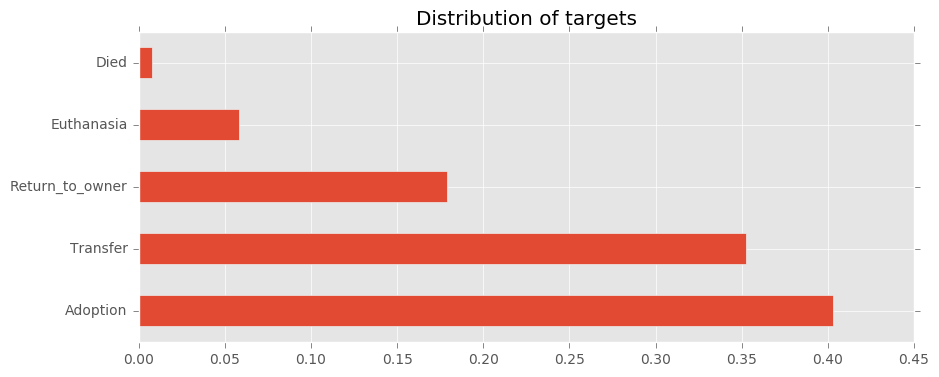

In [339]:
raw_data.OutcomeType.value_counts(normalize=True).plot(kind='barh', figsize=(10, 4), title='Distribution of targets')

It is great that most sheltered animals are either adopted or transferred, and only 6% of them are euthanasiaed. For our project purposes, it can be challenging to predict targets such as 'Died' or 'Euthanasia' because of the low percentage of occurances.

   * *Distribution of each feature*

#### AnimalType

In [340]:
print raw_data.AnimalType.value_counts()

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64


There are more dogs than cats in the training data, but both types have sufficient amount of data for us to train a model. 

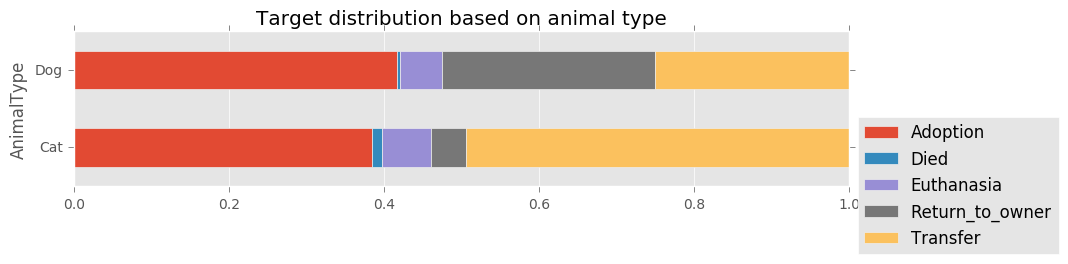

In [341]:
ax = raw_data.groupby(by='AnimalType')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,2), title='Target distribution based on animal type')
ax.legend(loc='best', bbox_to_anchor=(1.0, 0.5))

- Cats are disproportionally in the transfer category. Second, a lot more dogs were able to return to their owners than cats. These characteristics can be used to predict the outcomes. 

#### SexuponOutcome

In [342]:
print np.round(raw_data.SexuponOutcome.value_counts(normalize=True),2)

Neutered Male    0.37
Spayed Female    0.33
Intact Male      0.13
Intact Female    0.13
Unknown          0.04
Name: SexuponOutcome, dtype: float64


- There are about the same numbers of male vs female. Interestingly, Majority of animals are either neutered or spayed, which can increase the adoptability since on average neutered or spayed animals have better health on average.

- 4% of animals have unknown gender, which we need to handle it later when we do feature engineering. 

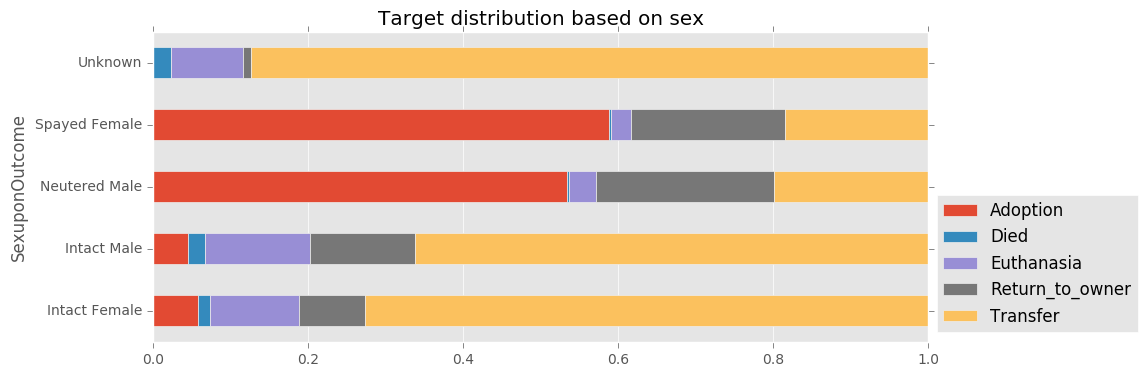

In [343]:
ax = raw_data.groupby(by='SexuponOutcome')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,4), title='Target distribution based on sex')
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

- Neutered or spayed pets are much more likely to be adopted. One reason could be the cost associated with undergoing such surgeries, which discourage adopters to choose an intact pet. On the other hand, whether the sheltered animals are male or female does not seem to make a difference in terms of outcome. This information can be useful when we do feature engineering. Lastly, there is an "unknown" type that seems to be closer to intact female. 

#### AgeuponOutcome

- The AgeuponOutcome variable is stored as a string containing an amount and a unit.  
- We will convert these into days so that we have a continous variable when we build the model. For EDA purposes we will first look at it categorically.

In [344]:
data = raw_data.copy()

# Convert ages to categories for EDA purposes
data['AgeuponOutcome'] = data['AgeuponOutcome'].fillna('99 years')
def age_handle(data):
    out = []
    for i in range(0, len(data)):
        if 'year' in data[i]:
            temp = int(re.sub(' [a-z]+', '', data[i]))
            if temp >= 11:
                out.append('super senior')
            elif temp >= 8:
                out.append('senior')
            elif temp <= 1:
                out.append('<1yr adult') #adult
            elif temp <= 3:
                out.append('1-3yr adult')
            else:
                out.append('>3yr adult')
        elif 'month' in data[i]:
            temp = int(re.sub(' [a-z]+', '', data[i]))
            if temp <= 1:
                out.append('1m pup')
            elif temp <= 2:
                out.append('2m pup')
            elif temp <= 3:
                out.append('3m pup')
            else:
                out.append('>3m pup')
        elif 'week' in data[i]:
            out.append('baby')
        elif 'day' in data[i]:
            out.append('baby')
    
    return out

data.AgeuponOutcome = age_handle(data.AgeuponOutcome)

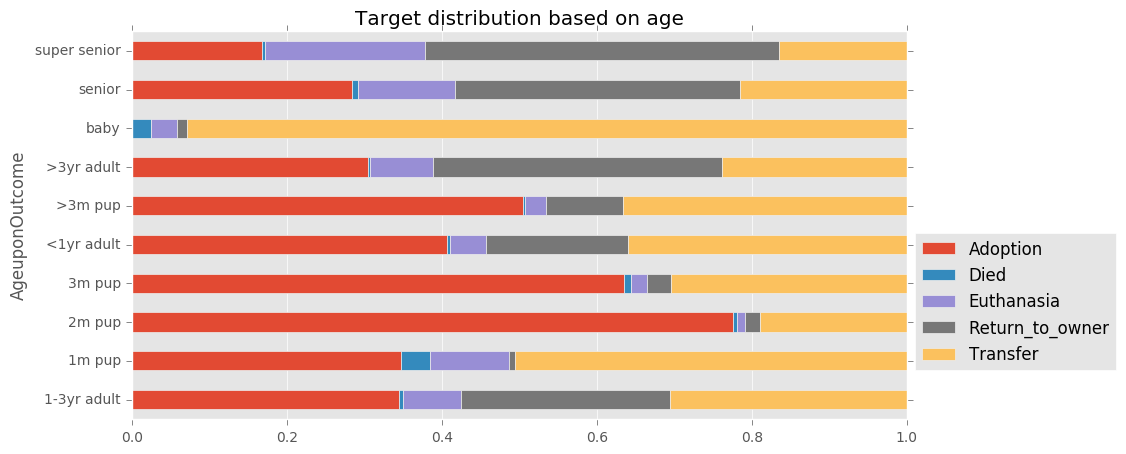

In [345]:
ax = data.groupby(by='AgeuponOutcome')['OutcomeType'].value_counts(normalize=True).unstack().plot(title='Target distribution based on age', kind='barh', stacked='True', figsize=(10,5))
ax.legend(loc='best', bbox_to_anchor=(1.0, 0.5))

- Majority of animals are younger than 1 year. The reason can be because most pet owners cannot handle so many babies at the same time so they have to abandom some of them. We can see that the number gradually decreases as the age increases.


- The younger the animals, the more likely they will be adopted. However, this is not true in the infant case where there are no adoption case. It is probably because animals that are younger than 2 months are not made available to be adopted, as it requires extra care. 


- On the other hand, the older the animals, the more likely they will either be euthanized or returned to their owners. Both scenarios make intuitive sense. Older animals are probably owned and hence more likely to be returned. Also, older animals tend to have worse health and people typically prefer to adopt younger animals, so they are more likely to be euthanized. 

#### Datetime

In [346]:
# Categorize hours into various intervals of a day
temp = pd.to_datetime(data['DateTime']).dt.hour
bins = [3, 7, 10, 14, 17, 20, 24]

# Different segments of the day
names = ['midnight','morning', 'lunch', 'afternoon','night', 'late night']
data['OutcomeHour'] = pd.cut(temp, bins, labels=names)

temp = pd.to_datetime(test_data['DateTime']).dt.hour
test_data['OutcomeHour'] = pd.cut(temp, bins, labels=names)

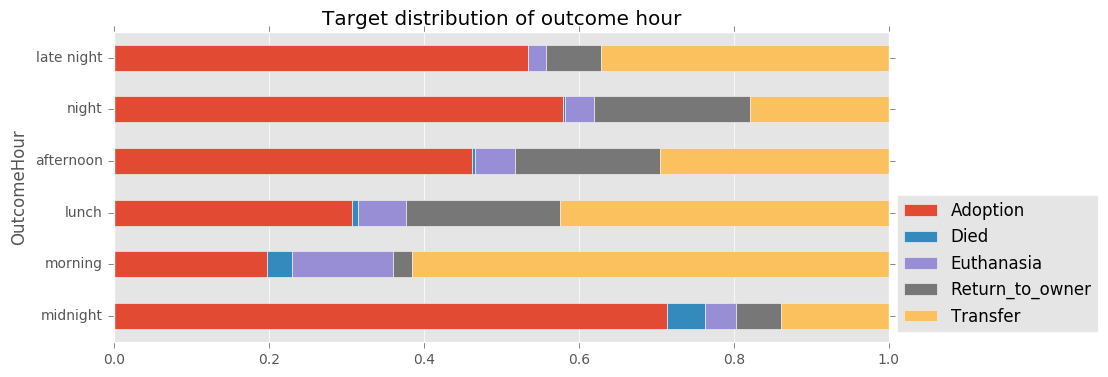

In [347]:
ax = data.groupby(by='OutcomeHour')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,4), title='Target distribution of outcome hour')
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

- We notice that a lot of adoption occurred during night time, which is surprising since we expect that to happen during afternoon. We also see more transferring and euthanasia happen in the morning, which can make sense since morning is less busy with adoption.

#### Breed

- There are way too many types of breed in the data. We will use feature hashing techniques and category reduction to handle it. Additionally, one thing we can do is to categorize breeds that are popular in America versus breeds that are typically not 'loved' by general public.

In [348]:
len(data.Breed.unique())

1380

In [349]:
# Examine whether popular/unpopular breed make a difference
popular_names = ['german shepherd', 'labrador', 'golden retriever', 'beagle', 'bulldog', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund']
unpopular_names = ['pit bull', 'chihuahua']

# Use countvectorizer function
cv = CountVectorizer(vocabulary=popular_names)
test = cv.fit_transform(data['Breed'])

# I only want a dummy variable
test = np.sum(test.toarray(), axis=1)
test[test==2] = 1

data['popular'] = test

data['unpopular'] = data.Breed.str.contains('Chihuahua') + data.Breed.str.contains('Pit Bull')

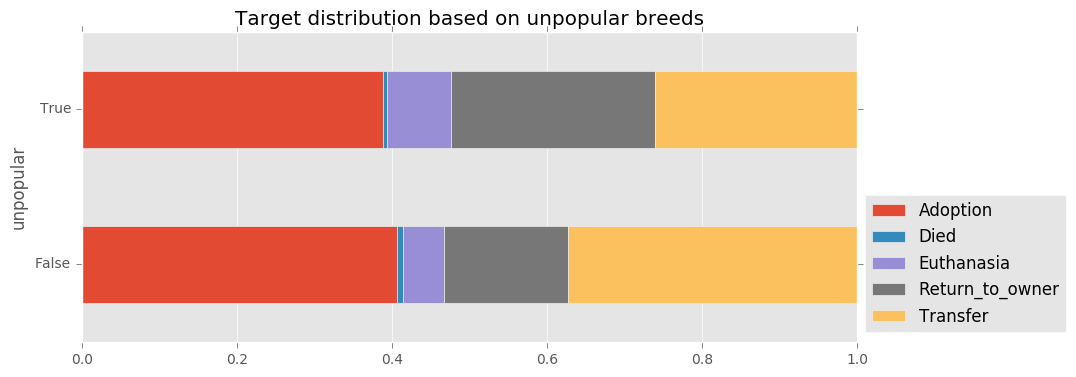

In [350]:
ax = data.groupby(by='unpopular')['OutcomeType'].value_counts(normalize=True).unstack().plot(title='Target distribution based on unpopular breeds',kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

- Unpopular dogs have slightly larger percentage of euthanasia, albeit it is small.

#### Color

- Similar to breed, there are too many color types for us to visualize. What we can potentially look at is to see whether there is a difference between mix color versus pure color. 

In [351]:
len(data.Color.unique())

366

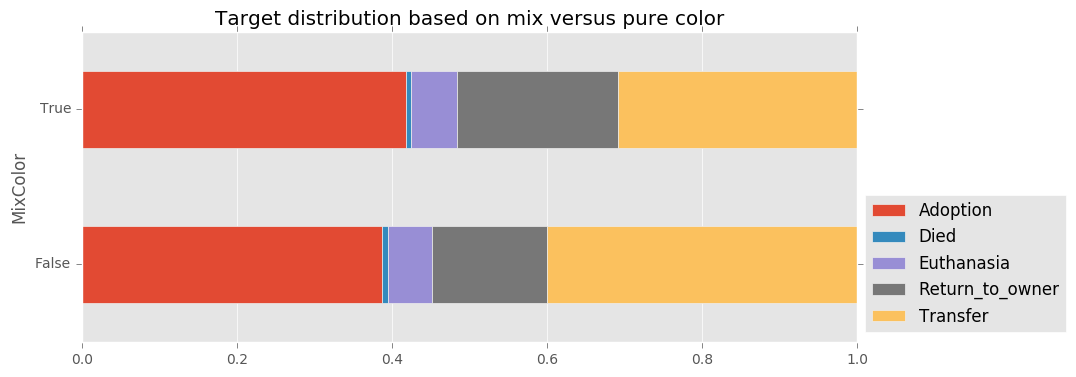

In [352]:
# Identify animals that have mix colors and check whether their outcomes are different
temp = ['/' in data.Color[x] for x in range(0, len(data.Color))]
data['MixColor'] = temp

ax = data.groupby(by='MixColor')['OutcomeType'].value_counts(normalize=True).unstack().plot(title='Target distribution based on mix versus pure color', kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

### Missing Values

Fortunately, most columns do not have missing values. The only two features that have missing values are 'Name' and 'Age'.

#### Name

We decided to use the missing value to create a new feature. The idea is that animals that do not have names may be less likely to be returned to owners.

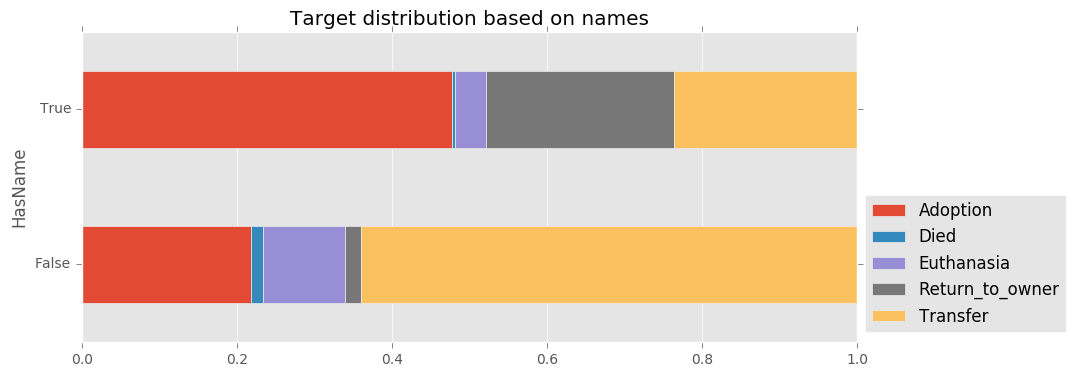

In [353]:
data['HasName'] = -data['Name'].isnull()

ax = data.groupby(by='HasName')['OutcomeType'].value_counts(normalize=True).unstack().plot(title='Target distribution based on names', kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

In line with our intutition, animals that have no names are much less likely to be returned to their owners. We also see lower adoption rate, and a higher euthanasia rate.

**Relationship Between Features**

In order to compare different features we convert categorical variables into integers

In [354]:
le = preprocessing.LabelEncoder()
data['AnimalType'] = le.fit_transform(data['AnimalType'])
data['SexuponOutcome'] = le.fit_transform(data['SexuponOutcome'])
data['AgeuponOutcome'] = le.fit_transform(data['AgeuponOutcome'])
data['OutcomeHour'] = le.fit_transform(data['OutcomeHour'])
# Calculate a correlation matrix of all features
data.loc[:,['AnimalType','SexuponOutcome','AgeuponOutcome','OutcomeHour','popular','unpopular','MixColor','HasName']].corr()

,AnimalType,SexuponOutcome,AgeuponOutcome,OutcomeHour,popular,unpopular,MixColor,HasName
AnimalType,1.000000,0.092029,-0.054914,-0.081887,0.458788,0.403973,0.284541,0.304307
SexuponOutcome,0.092029,1.000000,-0.011468,0.005000,0.067792,0.001807,0.037798,0.221411
AgeuponOutcome,-0.054914,-0.011468,1.000000,-0.005018,-0.008570,-0.065853,-0.047636,-0.101854
OutcomeHour,-0.081887,0.005000,-0.005018,1.000000,-0.035889,-0.042510,-0.007766,-0.093785
popular,0.458788,0.067792,-0.008570,-0.035889,1.000000,-0.105533,0.074938,0.121434
unpopular,0.403973,0.001807,-0.065853,-0.042510,-0.105533,1.000000,0.171163,0.133138
MixColor,0.284541,0.037798,-0.047636,-0.007766,0.074938,0.171163,1.000000,0.113565
HasName,0.304307,0.221411,-0.101854,-0.093785,0.121434,0.133138,0.113565,1.000000


It seems that our features are not strongly correlated with each other, which is very important when we apply prediction algorithm such as logistic regression.  

### Data Preparation
We have completed several modifications to the dataset in order to enrich the features and tested their improvements on predictive modeling.  Each step is completed on both the training and test sets.  All modifications are performed on the `raw_data` and `test_data` sets

#### AgeuponOutcome
As mentioned above, we will standardize the age feature as days. For example, 2 years = 730 days.

In [355]:
# A fresh copy of raw data
train_data = raw_data.copy()

In [356]:
#Separate age into a number and a string
train_data['Age_num'] = train_data['AgeuponOutcome'].str[:2].str.strip().astype(int, raise_on_error=False)
train_data['Age_str'] = train_data['AgeuponOutcome'].str[2:].str.strip()

test_data['Age_num'] = test_data['AgeuponOutcome'].str[:2].str.strip().astype(int, raise_on_error=False)
test_data['Age_str'] = test_data['AgeuponOutcome'].str[2:].str.strip()

#Create an age factor column based on each possible unit of measure
factor = {'years':365, 'year':365, 'month':30, 'months':30, 'week': 7, 'weeks':7, 'day':1, 'days':1}
train_data['Age_factor'] = train_data['Age_str'].map(lambda x: factor[x] if x in factor.keys() else 0)
test_data['Age_factor'] = test_data['Age_str'].map(lambda x: factor[x] if x in factor.keys() else 0)

#Multiply the number in the age by the factor for comparable numerical column.  Drop and derivitive columns
train_data['Age_num'] = train_data['Age_num'].astype(float)
train_data['Age_days'] = train_data['Age_num'].mul(train_data['Age_factor'], axis='index').fillna(0)
train_data.drop(['AgeuponOutcome', 'Age_num', 'Age_str', 'Age_factor'], 1, inplace = True)

test_data['Age_num'] = test_data['Age_num'].astype(float)
test_data['Age_days'] = test_data['Age_num'].mul(test_data['Age_factor'], axis='index').fillna(0)
test_data.drop(['AgeuponOutcome', 'Age_num', 'Age_str', 'Age_factor'], 1, inplace = True)

#### DateTime
We turn a single timestamp feature into various components such as year, month, day, hour, minute, and whether or not it was a weekend.

In [357]:
#Build up date features. Extract year, month, age, hour out of the datetime feature 
train_data['DateTime'] = train_data['DateTime'].astype(np.datetime64)
train_data['Year'] = train_data['DateTime'].map(lambda x: x.year)
train_data['Month'] = train_data['DateTime'].map(lambda x: x.month)
train_data['Day'] = train_data['DateTime'].map(lambda x: x.day)
train_data['Hour'] = train_data['DateTime'].map(lambda x: x.hour)

test_data['DateTime'] = test_data['DateTime'].astype(np.datetime64)
test_data['Year'] = test_data['DateTime'].map(lambda x: x.year)
test_data['Month'] = test_data['DateTime'].map(lambda x: x.month)
test_data['Day'] = test_data['DateTime'].map(lambda x: x.day)
test_data['Hour'] = test_data['DateTime'].map(lambda x: x.hour)

# Extract a feature 'weekend'
temp = pd.to_datetime(raw_data['DateTime']).dt.weekday
train_data['weekend'] = temp.isin([5,6])
temp = pd.to_datetime(test_data['DateTime']).dt.weekday
test_data['weekend'] = temp.isin([5,6])


#### Breed
We split multiple breeds into a primary and secondary breed feature, as well as generating a `Mix` column for those that are identified as a mixed breed

In [358]:
#Does the breed contain a mix?
train_data['Mix'] = train_data['Breed'].map(lambda x: x.find('Mix') != -1)
test_data['Mix'] = test_data['Breed'].map(lambda x: x.find('Mix') != -1)
#Split breed into first and second
train_data['First_Breed'] = train_data['Breed'].map(lambda x: x.split('/')[0].replace('Mix', '').strip())
test_data['First_Breed'] = test_data['Breed'].map(lambda x: x.split('/')[0].replace('Mix', '').strip())
train_data['Second_Breed'] = train_data['Breed'].map(lambda x: x.split('/')[1].replace('Mix', '').strip() if len(x.split('/')) > 1 else np.nan)
test_data['Second_Breed'] = test_data['Breed'].map(lambda x: x.split('/')[1].replace('Mix', '').strip() if len(x.split('/')) > 1 else np.nan)
train_data.drop('Breed', inplace=True, axis=1)
test_data.drop('Breed', inplace=True, axis=1)


#### Name
Name has far too many unique categories, we we instead reduced it into a binary variable of whether or not the animal had a name

In [359]:
#Does the animal have a name?
train_data['has_name'] = train_data['Name'].isnull()
test_data['has_name'] = test_data['Name'].isnull()
train_data.drop('Name', inplace=True, axis=1)
test_data.drop('Name', inplace=True, axis=1)

#### Color
Similar to breed, there can be multiple colors listed as well as the string `mix`.  We split the colors into a first and second color, as well as a mixed color feature.

In [360]:
# Split color to primary versus secondary if exist
train_data['First_Color'] = train_data['Color'].map(lambda x: x.split('/')[0].replace('Mix', '').strip())
train_data['Second_Color'] = train_data['Color'].map(lambda x: x.split('/')[1].replace('Mix', '').strip() if len(x.split('/')) > 1 else np.nan)

test_data['First_Color'] = test_data['Color'].map(lambda x: x.split('/')[0].replace('Mix', '').strip())
test_data['Second_Color'] = test_data['Color'].map(lambda x: x.split('/')[1].replace('Mix', '').strip() if len(x.split('/')) > 1 else np.nan)

# Extract a feature if the animal has mix colors
train_data['Mix_Color'] = train_data['Color'].map(lambda x: x.find('Mix') != -1)
test_data['Mix_Color'] = test_data['Color'].map(lambda x: x.find('Mix') != -1)

train_data.drop('Color', axis=1, inplace=True)
test_data.drop('Color', axis=1, inplace=True)


#### Feature Hashing
Many of the features are categorical with potentially thousands of unique values.  In order to better model the data, we turn each possible category into its own feature.  After testing we found that removing some of the more rare categories, and simply lumping them into a `Rare_Breed` feature improved results.

In [361]:
train_data.columns.values

array(['AnimalID', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'Age_days', 'Year', 'Month', 'Day',
       'Hour', 'weekend', 'Mix', 'First_Breed', 'Second_Breed', 'has_name',
       'First_Color', 'Second_Color', 'Mix_Color'], dtype=object)

In [362]:
# Use dictionary vectorizer to do feature hashing
dv = DictVectorizer(sparse=False)

# Features that we want to hash
hash_preds = ['AnimalType','SexuponOutcome','First_Breed', 'Second_Breed','First_Color','Second_Color', 'Year','Month','Day','Age_days','Hour']

# Features that do not need to be hashed
non_hash_preds = ['OutcomeType', 'weekend', 'Mix', 'has_name', 'Mix_Color']

hashed_train = pd.DataFrame(dv.fit_transform(train_data[hash_preds].to_dict(orient='records')), 
                            columns=dv.get_feature_names()).fillna(0)
hashed_test = pd.DataFrame(dv.transform(test_data[hash_preds].to_dict(orient='records')), 
                           columns=dv.get_feature_names()).fillna(0)

In [363]:
hashed_train.shape

(26729, 478)

In [364]:
hashed_train.head()

,Age_days,AnimalType=Cat,AnimalType=Dog,Day,First_Breed=Abyssinian,First_Breed=Affenpinscher,First_Breed=Afghan Hound,First_Breed=Airedale Terrier,First_Breed=Akita,First_Breed=Alaskan Husky,...,Second_Color=White,Second_Color=Yellow,Second_Color=Yellow Brindle,SexuponOutcome,SexuponOutcome=Intact Female,SexuponOutcome=Intact Male,SexuponOutcome=Neutered Male,SexuponOutcome=Spayed Female,SexuponOutcome=Unknown,Year
0,365.0,0.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014.0
1,365.0,1.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2013.0
2,730.0,0.0,1.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015.0
3,21.0,1.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2014.0
4,730.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2013.0


In [365]:
# Merge hashed and non-hashed features
final_train_data = train_data[non_hash_preds].merge(hashed_train, how='inner', left_index=True, right_index=True)
final_test_data = test_data[non_hash_preds[1:]].merge(hashed_test, how = 'inner', left_index=True, right_index=True)

In [366]:
final_train_data.head()

,OutcomeType,weekend,Mix,has_name,Mix_Color,Age_days,AnimalType=Cat,AnimalType=Dog,Day,First_Breed=Abyssinian,...,Second_Color=White,Second_Color=Yellow,Second_Color=Yellow Brindle,SexuponOutcome,SexuponOutcome=Intact Female,SexuponOutcome=Intact Male,SexuponOutcome=Neutered Male,SexuponOutcome=Spayed Female,SexuponOutcome=Unknown,Year
0,Return_to_owner,False,True,False,False,365.0,0.0,1.0,12.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014.0
1,Euthanasia,True,True,False,False,365.0,1.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2013.0
2,Adoption,True,True,False,False,730.0,0.0,1.0,31.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015.0
3,Transfer,False,True,True,False,21.0,1.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2014.0
4,Transfer,False,False,True,False,730.0,0.0,1.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2013.0


### Label

We will convert the outcome to numeric

In [367]:
# Convert the label to numeric category
le = preprocessing.LabelEncoder()
train_labels = le.fit_transform(final_train_data['OutcomeType'])

final_train_data = final_train_data.drop(['OutcomeType'], axis=1)

In [370]:
final_train_data.to_csv('train_data_engineered.csv', index=False)
final_test_data.to_csv('test_data_engineered.csv', index=False)

## Modeling

### What model are we using?  Why?

In [371]:
final_train_data.head()

,weekend,Mix,has_name,Mix_Color,Age_days,AnimalType=Cat,AnimalType=Dog,Day,First_Breed=Abyssinian,First_Breed=Affenpinscher,...,Second_Color=White,Second_Color=Yellow,Second_Color=Yellow Brindle,SexuponOutcome,SexuponOutcome=Intact Female,SexuponOutcome=Intact Male,SexuponOutcome=Neutered Male,SexuponOutcome=Spayed Female,SexuponOutcome=Unknown,Year
0,False,True,False,False,365.0,0.0,1.0,12.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014.0
1,True,True,False,False,365.0,1.0,0.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2013.0
2,True,True,False,False,730.0,0.0,1.0,31.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015.0
3,False,True,True,False,21.0,1.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2014.0
4,False,False,True,False,730.0,0.0,1.0,15.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2013.0


In [372]:
clf = GradientBoostingClassifier(n_estimators=200, subsample=0.8)
#gs = GridSearchCV(dt,parameter)

clf.fit(final_train_data, train_labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=0.8, verbose=0, warm_start=False)

In [373]:
le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

In [374]:
pred_prob = clf.predict_proba(final_test_data)

In [375]:
np.savetxt('prediction.csv', pred_prob)

### Assumptions?

### Regularization?

## Evaluation

### How well does the model perform?
- Accuracy
- ROC Curves
- Cross-validation
- other metrics?  performance?

#### AB test results (if any)

## Deployment

#### How is the model deployed?
- prediction service?
- serialized model?
- regression coefficients?

#### What support is provided after initial deployment?